In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
import holidays

import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv('AssignmentData.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.datetime=pd.to_datetime(df.datetime)
df.drop('date',axis=1,inplace=True)

In [4]:
def time_features(train1):

    train1['Year']=train1.index.year
    train1['Hours']=train1.index.hour
    # train1['Minutes']=train1.index.minute
    train1['Month']=train1.index.month
    # train1['Day']=train1.index.day

    train1['quarter'] = train1.index.quarter
    train1['dayofyear'] = train1.index.dayofyear
    train1['weekofyear'] = train1.index.weekofyear

    train1['day_cos'] = [np.cos(x * (2 * np.pi / 24)) for x in train1['Hours']]
    train1['day_sin'] = [np.sin(x * (2 * np.pi / 24)) for x in train1['Hours']]

    train1['day_sin'] = [round(x, 3) for x in train1['day_sin']]
    train1['day_cos'] = [round(x, 3) for x in train1['day_cos']]

    train1['week/end']=list(pd.to_datetime(train1.reset_index().datetime).dt.dayofweek.apply(lambda x: 1 if (x==5)|(x==6) else 0))

    train1['timestamp'] = [x.timestamp() for x in train1.reset_index().datetime]

    # Seconds in day 
    s = 24 * 60 * 60 

    # Seconds in year 
    year = (365.25) * s

    train1['month_cos'] = [np.cos((x) * (2 * np.pi / year)) for x in train1['timestamp']]
    train1['month_sin'] = [np.sin((x) * (2 * np.pi / year)) for x in train1['timestamp']]

    return train1


In [5]:
def lag_features_1(df,window=10):

    # feature_cols = ['apparent_temperature','humidity', 'dew_point','wind_speed', 'cloud_cover',]
    feature_cols=['load','apparent_temperature']
    df_site = df
    
    df_rolled = df_site[feature_cols].rolling(window=window, min_periods=0)
    
    df_mean = df_rolled.mean().astype(np.float16)
    df_median = df_rolled.median().astype(np.float16)
    df_min = df_rolled.min().astype(np.float16)
    df_max = df_rolled.max().astype(np.float16)
    df_std = df_rolled.std().astype(np.float16)
    df_skew = df_rolled.skew().astype(np.float16)
    
    for feature in feature_cols:
        
        df[f"{feature}_mean_lagn{window}"] = list(df_mean[feature])
        df[f"{feature}_median_lagn{window}"] = list(df_median[feature])
        df[f"{feature}_min_lagn{window}"] = list(df_min[feature])
        df[f"{feature}_max_lagn{window}"] = list(df_max[feature])
        df[f"{feature}_std_lagn{window}"] = list(df_std[feature])
        df[f"{feature}_skew_lagn{window}"] = list(df_skew[feature])

    return df

In [6]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))

def mae(y, t):
  return np.mean(np.abs(y - t))

In [7]:
states=['CG', 'GJ','BR', 'RJ','HR','MP', 'UP', 'UK']
dates=[]
for i in states:
    for j in [2018,2019,2020]:
        for date,_ in holidays.India(years=j,prov=i).items():
            dates.append(date)

for j in [2018,2019,2020]:
    for date,_ in holidays.India(years=j).items():
        dates.append(date)

In [8]:
def data_prep(df,index,days_to_pred):

    train1=df.iloc[:index,:].set_index('datetime')

    train1.dropna(inplace=True)

    train1['shifted_load_1day']=train1.load.shift(-96)
    train1['shifted_load_2day']=train1.load.shift(-192)
    train1['shifted_load_3day']=train1.load.shift(-288)
    train1['shifted_load_4day']=train1.load.shift(-384)

    train1=time_features(train1)

    lag_features_1(train1,4),lag_features_1(train1,6),lag_features_1(train1,8),lag_features_1(train1,12)
    lag_features_1(train1,32),lag_features_1(train1,64),lag_features_1(train1,96),lag_features_1(train1,96+32)
    lag_features_1(train1,96+96),lag_features_1(train1,96+96+96),lag_features_1(train1,96+96+96+96)
    print('done')

    val_pred_input=train1[train1.shifted_load_1day.isna()]

    train1['holiday']=list(train1.reset_index().datetime.apply(lambda x : 1 if x in list(set(dates)) else 0))

    val_pred_input['holiday']=list(val_pred_input.reset_index().datetime.apply(lambda x : 1 if x in list(set(dates)) else 0))


    day1=train1.drop(['shifted_load_2day','shifted_load_3day','shifted_load_4day'],axis=1)
    day2=train1.drop(['shifted_load_1day','shifted_load_3day','shifted_load_4day'],axis=1)
    day3=train1.drop(['shifted_load_1day','shifted_load_2day','shifted_load_4day'],axis=1)
    day4=train1.drop(['shifted_load_1day','shifted_load_2day','shifted_load_3day'],axis=1)

    day1.dropna(inplace=True)
    day2.dropna(inplace=True)
    day3.dropna(inplace=True)
    day4.dropna(inplace=True)

    return day1,day2,day3,day4,val_pred_input



In [9]:
import xgboost

In [10]:
def model(X1,y1,val_pred_input):
    
    model1 = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

    model1.fit(X1,y1)
    return model1.predict(val_pred_input)


In [11]:
day_1_col=['load_min_lagn96', 'load_mean_lagn4', 'load', 'load_max_lagn384', 'week/end',
 'apparent_temperature_median_lagn96', 'load_max_lagn6', 'apparent_temperature_mean_lagn192',
 'Hours', 'apparent_temperature_max_lagn8', 'apparent_temperature_max_lagn96',
 'load_min_lagn128', 'apparent_temperature_median_lagn192', 'apparent_temperature_max_lagn12',
 'month_cos', 'load_max_lagn4', 'load_std_lagn384', 'apparent_temperature_max_lagn192',
 'load_median_lagn4', 'apparent_temperature_min_lagn64', 'day_cos', 'apparent_temperature_max_lagn32',
 'load_median_lagn6', 'load_min_lagn384', 'load_min_lagn4']

In [12]:
day2_col=['load_max_lagn288','load_min_lagn96','load_mean_lagn4','load','week/end',
  'load_max_lagn384','apparent_temperature_median_lagn96','load_max_lagn6','apparent_temperature_mean_lagn32',
  'Hours','apparent_temperature_min_lagn12','apparent_temperature_max_lagn128',
  'apparent_temperature_max_lagn288','apparent_temperature_max_lagn12','month_cos',
  'load_max_lagn4','apparent_temperature_max_lagn192','load_median_lagn4','apparent_temperature_median_lagn288',
  'day_cos']

In [13]:
day3_col=['timestamp','load_max_lagn288','month_sin','dayofyear','load_min_lagn96','load_mean_lagn4',
  'load','load_max_lagn384','week/end','apparent_temperature_median_lagn96','load_median_lagn96',
  'Hours','load_max_lagn96','apparent_temperature_max_lagn288','apparent_temperature_max_lagn12',
  'month_cos','load_max_lagn4','apparent_temperature_max_lagn192','load_median_lagn4','apparent_temperature_median_lagn288']

In [14]:
day4_col=['timestamp','apparent_temperature_max_lagn6','load_max_lagn288',
  'load','load_mean_lagn4','week/end','load_max_lagn384','Hours','load_max_lagn96',
  'apparent_temperature_max_lagn96','month_cos','load_max_lagn4']

# 1

In [15]:
index=48000
no_of_days_to_predict=4

day1,day2,day3,day4,val_pred_input=data_prep(df,index,no_of_days_to_predict)
print(day1.shape)

X1=day1.drop('shifted_load_1day',axis=1)[day_1_col]
y1=day1.shifted_load_1day
val_pred_input1=val_pred_input[list(X1.columns)]

df.iloc[index:index+96*1,1]=model(X1,y1,val_pred_input1)  # 1 

X2=day2.drop('shifted_load_2day',axis=1)[day2_col]
y2=day2.shifted_load_2day
val_pred_input2=val_pred_input[X2.columns]

df.iloc[index+96*1:index+96*2,1]=model(X2,y2,val_pred_input2)  # 2

X3=day3.drop('shifted_load_3day',axis=1)[day3_col]
y3=day3.shifted_load_3day
val_pred_input3=val_pred_input[X3.columns]

df.iloc[index+96*2:index+96*3,1]=model(X3,y3,val_pred_input3)  # 3

X4=day4.drop('shifted_load_4day',axis=1)[day4_col]
y4=day4.shifted_load_4day
val_pred_input4=val_pred_input[X4.columns]

df.iloc[index+96*3:index+96*4,1]=model(X4,y4,val_pred_input4)  # 4

done
(46715, 153)


# 2

In [16]:
index=53760
no_of_days_to_predict=4

day1,day2,day3,day4,val_pred_input=data_prep(df,index,no_of_days_to_predict)

X1=day1.drop('shifted_load_1day',axis=1)[day_1_col]
y1=day1.shifted_load_1day
val_pred_input1=val_pred_input[list(X1.columns)]

df.iloc[index:index+96*1,1]=model(X1,y1,val_pred_input1)  # 5

X2=day2.drop('shifted_load_2day',axis=1)[day2_col]
y2=day2.shifted_load_2day
val_pred_input2=val_pred_input[X2.columns]

df.iloc[index+96*1:index+96*2,1]=model(X2,y2,val_pred_input2)  # 6

X3=day3.drop('shifted_load_3day',axis=1)[day3_col]
y3=day3.shifted_load_3day
val_pred_input3=val_pred_input[X3.columns]

df.iloc[index+96*2:index+96*3,1]=model(X3,y3,val_pred_input3)   # 7


X4=day4.drop('shifted_load_4day',axis=1)[day4_col]
y4=day4.shifted_load_4day
val_pred_input4=val_pred_input[X4.columns]

df.iloc[index+96*3:index+96*4,1]=model(X4,y4,val_pred_input4)   # 8

done


# 3

In [17]:
index=63744
no_of_days_to_predict=1

day1,day2,day3,day4,val_pred_input=data_prep(df,index,no_of_days_to_predict)

X1=day1.drop('shifted_load_1day',axis=1)[day_1_col]
y1=day1.shifted_load_1day
val_pred_input1=val_pred_input[list(X1.columns)]

df.iloc[index:index+96*1,1]=model(X1,y1,val_pred_input1)  # 9

done


# 4   

In [19]:
index=69984
no_of_days_to_predict=2

day1,day2,day3,day4,val_pred_input=data_prep(df,index,no_of_days_to_predict)

print(day1.shape)

X1=day1.drop('shifted_load_1day',axis=1)[day_1_col]
y1=day1.shifted_load_1day
val_pred_input1=val_pred_input[list(X1.columns)]

df.iloc[index:index+96*1,1]=model(X1,y1,val_pred_input1)  # 10

X2=day2.drop('shifted_load_2day',axis=1)[day2_col]
y2=day2.shifted_load_2day
val_pred_input2=val_pred_input[X2.columns]

df.iloc[index+96*1:index+96*2,1]=model(X2,y2,val_pred_input2)  # 11

done
(68570, 153)


# 5

In [20]:
index=77856
no_of_days_to_predict=1

day1,day2,day3,day4,val_pred_input=data_prep(df,index,no_of_days_to_predict)

print(day1.shape)

X1=day1.drop('shifted_load_1day',axis=1)[day_1_col]
y1=day1.shifted_load_1day
val_pred_input1=val_pred_input[list(X1.columns)]

df.iloc[index:index+96*1,1]=model(X1,y1,val_pred_input1)  # 12

done
(76406, 153)


# 6

In [21]:
index=96768
no_of_days_to_predict=3

day1,day2,day3,day4,val_pred_input=data_prep(df,index,no_of_days_to_predict)

print(day1.shape)

X1=day1.drop('shifted_load_1day',axis=1)[day_1_col]
y1=day1.shifted_load_1day
val_pred_input1=val_pred_input[list(X1.columns)]

df.iloc[index:index+96*1,1]=model(X1,y1,val_pred_input1)  # 13

X2=day2.drop('shifted_load_2day',axis=1)[day2_col]
y2=day2.shifted_load_2day
val_pred_input2=val_pred_input[X2.columns]

df.iloc[index+96*1:index+96*2,1]=model(X2,y2,val_pred_input2)  # 14

X3=day3.drop('shifted_load_3day',axis=1)[day3_col]
y3=day3.shifted_load_3day
val_pred_input3=val_pred_input[X3.columns]

df.iloc[index+96*2:index+96*3,1]=model(X3,y3,val_pred_input3)  #15

done
(95328, 153)


# 7 

In [23]:
index=103392
no_of_days_to_predict=2

day1,day2,day3,day4,val_pred_input=data_prep(df,index,no_of_days_to_predict)

print(day1.shape)

X1=day1.drop('shifted_load_1day',axis=1)[day_1_col]
y1=day1.shifted_load_1day
val_pred_input1=val_pred_input[list(X1.columns)]

df.iloc[index:index+96*1,1]=model(X1,y1,val_pred_input1)  # 16

X2=day2.drop('shifted_load_2day',axis=1)[day2_col]
y2=day2.shifted_load_2day
val_pred_input2=val_pred_input[X2.columns]

df.iloc[index+96*1:index+96*2,1]=model(X2,y2,val_pred_input2)   #17


done
(101942, 153)


In [26]:
df.to_csv('forecasted.csv',index=False)

In [9]:
df=pd.read_csv('AssignmentData.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.datetime=pd.to_datetime(df.datetime)
df.drop('date',axis=1,inplace=True)

df1=pd.read_csv('forecasted.csv')
df1.datetime=pd.to_datetime(df.datetime)

-------------------original load data------------------------------


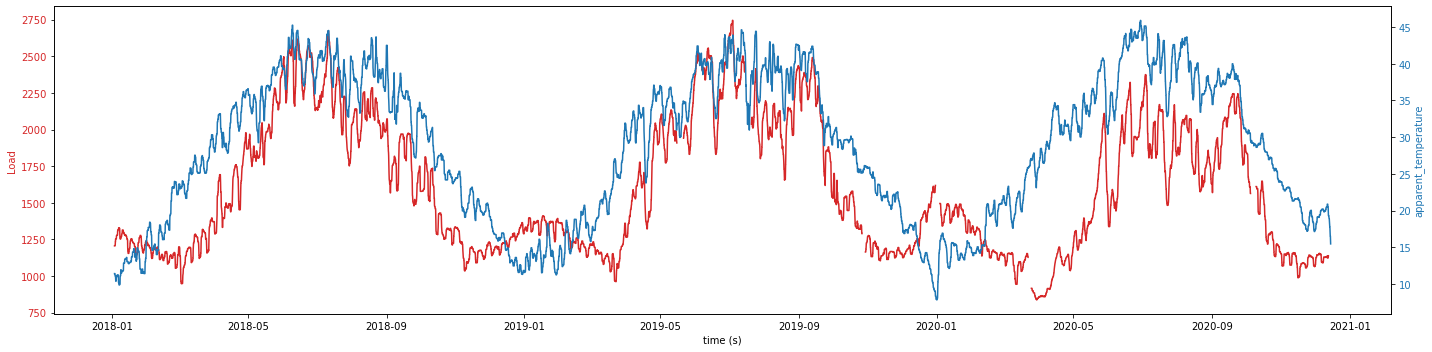

-------------------forecasted load data------------------------------


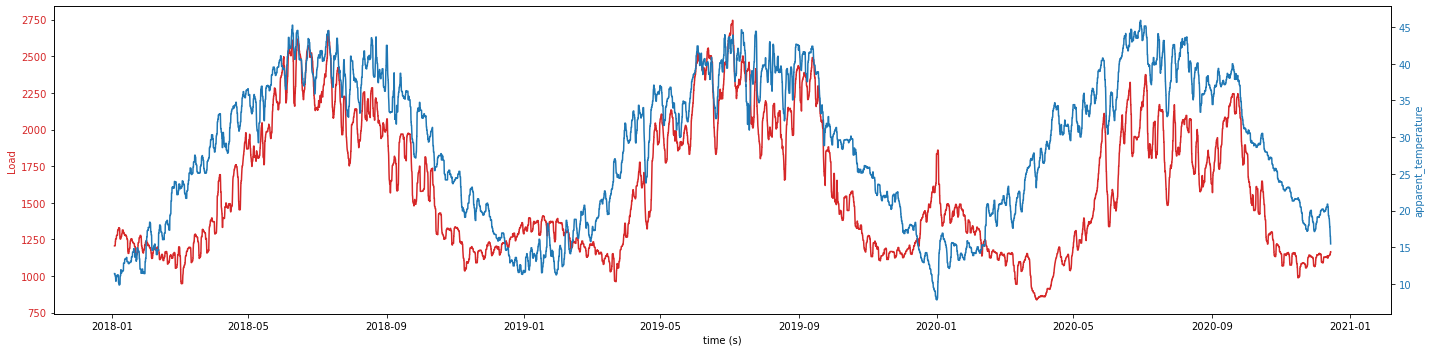

In [12]:
k1=df.drop('datetime',axis=1).rolling(96*2).median().set_index(df.datetime)

print('-------------------original load data------------------------------')

for i in df.columns[2:3]:

    fig, ax1 = plt.subplots(figsize=(20,5))

    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('Load', color=color)
    ax1.plot(k1.index, k1.load, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.set_ylabel(i, color=color)  
    ax2.plot(k1.index, k1[i], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

k1=df1.drop('datetime',axis=1).rolling(96*2).median().set_index(df.datetime)

print('-------------------forecasted load data------------------------------')

for i in df.columns[2:3]:

    fig, ax1 = plt.subplots(figsize=(20,5))

    color = 'tab:red'
    ax1.set_xlabel('time (s)')
    ax1.set_ylabel('Load', color=color)
    ax1.plot(k1.index, k1.load, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.set_ylabel(i, color=color)  
    ax2.plot(k1.index, k1[i], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

In [11]:
# Seeing the results , model is able to predict the variatons of load with respect to the temperature conditions
# But there is some abnomarlity , when it comes to the loacalised max/min load forecasting and there is noise
# in the predictions that need be addressed with model tuning or with feature engineering to regulate the output.